# Práctica Final: Clasificación con Scikit-learn y MLflow

**Dataset Seleccionado:** Amazon Reviews of the Sports and Outdoors category

**Cantidad de reviews:** 296,337

---

## 1. Exploración del corpus y análisis exploratorio

### Cargar y Preprocesar los Datos

**Campos descartados y razones:**
* **ReviewerID** contiene la identificación del usuario y considero que no aporta información sobre el sentimiento.
* **Asin** contiene el código del producto, podría ser útil si analizaramos productos específicos pero no influye directamente en el sentimiento.
* **ReviewerName** es el nombre del usuario así que es irrelevante para el análisis de sentimientos.
* **Summary:** contiene el resumen de la reseña, podría ser útil para otro análisis, pero el reviewText ya contiene toda la información.
* **Helpful**	contiene el número de votos útiles de la reseña, puede indicar calidad de la opinión, pero no el sentimiento en sí.
* **unixReviewTime / reviewTime**	Fecha de la reseña. Considero que no es necesario para el análisis de sentimiento.

**Campos seleccionados para el analisis:**
* En el analisís tendre en cuenta los campos Summary y reviewText porque puede que ambos campos ayuden a mejorar la clasificación.

## Instalar Dependencias

In [9]:
pip install swifter 

Note: you may need to restart the kernel to use updated packages.


"DOSKEY" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.
DEPRECATION: Loading egg at c:\users\asus\anaconda3\envs\bd14-despliegue-algo\lib\site-packages\huggingface_hub-0.29.0rc7-py3.8.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [11]:
pip install num2words

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13822 sha256=c1d7f9744ec43950d839348cacc928f6f9e601b248b7f6085e85e69f30c4df6c
  Stored in directory: c:\users\asus\appdata\local\pip\cache\wheels\1a\b0\8c\4b75c4116c31f83c8f9f047231251e13cc74481cca4a78a9ce
Successfully built docopt
Note: you may need to restart the kernel to use updated packages.


"DOSKEY" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.
DEPRECATION: Loading egg at c:\users\asus\anaconda3\envs\bd14-despliegue-algo\lib\site-packages\huggingface_hub-0.29.0rc7-py3.8.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330


## Cargar Dependencias

In [12]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import unicodedata
import swifter
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.decomposition import PCA
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from num2words import num2words
from nltk.util import ngrams
from nltk import RegexpTokenizer
from nltk.stem import WordNetLemmatizer


# Descargar recursos de NLTK
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

# Cargar las stopwords en inglés
stop_words = set(stopwords.words('english'))

ModuleNotFoundError: No module named 'nltk'

## Cargar Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

def readFileFromDrive(path):
  try:
    df = pd.read_json(path, lines=True)
    return df
  except FileNotFoundError:
    print(f"Error: File '{path}' not found.")
  except Exception as e:
    print(f"Ocurrs an error: {e}")

df = readFileFromDrive('/content/drive/MyDrive/Colab Notebooks/Sports_and_Outdoors_5.json')
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,AIXZKN4ACSKI,1881509818,David Briner,"[0, 0]",This came in on time and I am veru happy with ...,5,Woks very good,1390694400,"01 26, 2014"
1,A1L5P841VIO02V,1881509818,Jason A. Kramer,"[1, 1]",I had a factory Glock tool that I was using fo...,5,Works as well as the factory tool,1328140800,"02 2, 2012"
2,AB2W04NI4OEAD,1881509818,J. Fernald,"[2, 2]",If you don't have a 3/32 punch or would like t...,4,"It's a punch, that's all.",1330387200,"02 28, 2012"
3,A148SVSWKTJKU6,1881509818,"Jusitn A. Watts ""Maverick9614""","[0, 0]",This works no better than any 3/32 punch you w...,4,It's a punch with a Glock logo.,1328400000,"02 5, 2012"
4,AAAWJ6LW9WMOO,1881509818,Material Man,"[0, 0]",I purchased this thinking maybe I need a speci...,4,"Ok,tool does what a regular punch does.",1366675200,"04 23, 2013"


In [ ]:
# Ver el contenido de los 50 primeros items
pd.set_option("display.max_colwidth", 200)
df[["reviewText", "overall"]].head(50)

,reviewText,overall
0,"This came in on time and I am veru happy with it, I haved used it already and it makes taking out the pins in my glock 32 very easy",5
1,"I had a factory Glock tool that I was using for my Glock 26, 27, and 17. I've since lost it and had needed another. Since I've used Ghost products prior, and know that they are reliable, I had d...",5
2,"If you don't have a 3/32 punch or would like to have one in your Glock bag, this is okay. The butt end of it is handy for pushing pins back in place. If you already have a 3/32 punch and don't n...",4
3,"This works no better than any 3/32 punch you would find at the hardware store. Actually, I think you would be better with a regular punch as it has more to hold on to.",4
4,"I purchased this thinking maybe I need a special tool to easily pop off my base plates for my magazines, but it does the same as a regular punch tool. Glock mags are a pain to get the base plates ...",4
5,"Needed this tool to really break down my G22, and it works perfectly for that. No difference from OEM I suspect.However, had an added bonus when realizing that I needed a punch to properly disasse...",5
6,If u don't have it .. Get it. All you need to completely take down your glock. Any model any gen.,5
7,"This light will no doubt capture the attention of night-time drivers. It has three functions for the LED, blinking, strobe (kind of) and solid. The lasers project well and can be set to flash or r...",4
8,"Light and laser torch work well, very bright. Just installed on trike, had it a week, but seems to be well built. Only time will tell.",5
9,"Does everything it says it will do. I would like it so that the &#34;lane&#34; markings were a bit brighter on the ground. This does add a bit of safety to riding in the dark, as long as the motor...",5


## Cardinalidad del vocabulario

In [ ]:
# Calcular cuántas palabras únicas hay en el corpus
def get_vocab_size(df):
    all_text = ' '.join(df['reviewText'].dropna()).lower()
    words = set(word_tokenize(all_text))
    return len(words)

vocab_size = get_vocab_size(df)
print(f"Cardinalidad del vocabulario: {vocab_size} palabras únicas")

Cardinalidad del vocabulario: 294822 palabras únicas


## Distribución de reviews por número de estrellas

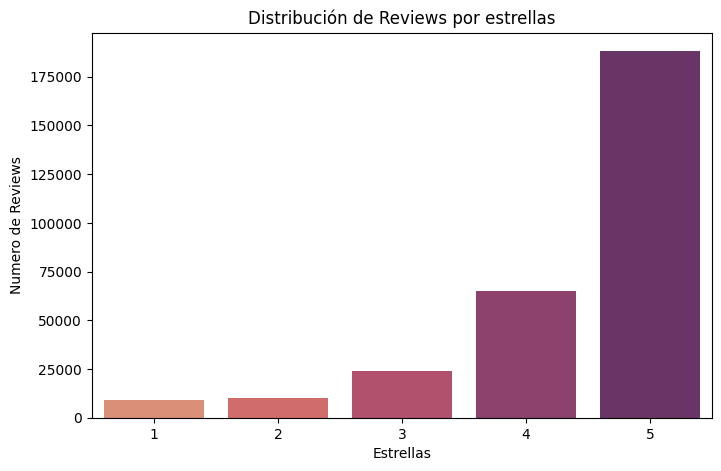

In [ ]:
# Ver cómo se distribuyen las calificaciones en las reviews. Esto nos ayudará a ver si hay un sesgo en la distribución de calificaciones.
plt.figure(figsize=(8,5))
sns.countplot(x=df['overall'], palette="flare")
plt.title("Distribución de Reviews por estrellas")
plt.xlabel("Estrellas")
plt.ylabel("Numero de Reviews")
plt.show()

## Nº de reviews positivas y negativas

Pandas Apply:   0%|          | 0/296337 [00:00<?, ?it/s]

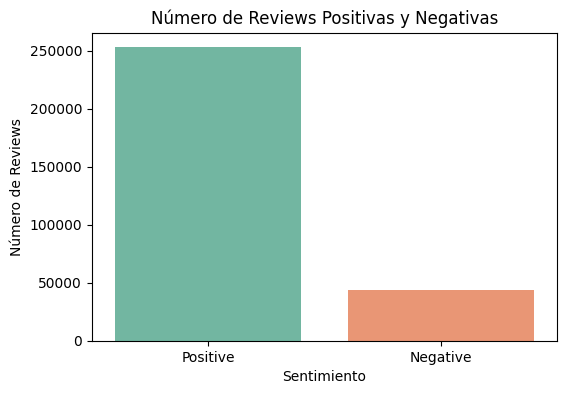

In [ ]:
# Considero que las reviews positivas tienen 4 y 5 estrellas.
# Y como reviews negativas las que tengan 1, 2 y 3 estrellas.
df['sentiment'] = df['overall'].swifter.apply(lambda x: 'Positive' if x >= 4 else 'Negative')

plt.figure(figsize=(6,4))
sns.countplot(x=df['sentiment'], palette="Set2")
plt.title("Número de Reviews Positivas y Negativas")
plt.xlabel("Sentimiento")
plt.ylabel("Número de Reviews")
plt.show()

## N-grams más frecuentes

In [ ]:
tokenizer = RegexpTokenizer(r'\w+')  # Tokenizer que mantiene solo palabras
stop_words = set(stopwords.words('english'))  # Stopwords en inglés
lemmatizer = WordNetLemmatizer()  # Lematizador

# Función optimizada para limpieza de texto
def clean_text(text):
    if not isinstance(text, str):  # Manejar valores NaN o no string
        return []

    # Normalizar texto eliminando acentos y caracteres especiales
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

    # Tokenizar eliminando puntuación
    words = tokenizer.tokenize(text.lower())

    # Eliminar stopwords y aplicar lematización
    clean_words = []
    for word in words:
        if word not in stop_words:
            clean_word = lemmatizer.lemmatize(word).strip()  # Lematizar
            if clean_word.isdigit():  # Convertir números a palabras
                clean_word = num2words(clean_word, lang='en')
            clean_words.append(clean_word)

    return clean_words

# Aplicar la función con Swifter para paralelizar el proceso en Pandas
df['tokens'] = df['reviewText'].swifter.apply(clean_text)

Pandas Apply:   0%|          | 0/296337 [00:00<?, ?it/s]

In [ ]:
# Generar unigrams y bigrams de manera eficiente
unigrams = [word for review in df['tokens'] for word in review]
bigrams = [b for review in df['tokens'] for b in ngrams(review, 2)]
trigrams = [t for review in df['tokens'] for t in ngrams(review, 3)]

# Contar frecuencia de palabras
unigram_counts = Counter(unigrams).most_common(10)
bigram_counts = Counter(bigrams).most_common(10)
trigrams_counts = Counter(trigrams).most_common(10)

print("📌 Unigrams más frecuentes:", unigram_counts)
print("📌 Bigrams más frecuentes:", bigram_counts)
print("📌 Trigrams más frecuentes:", trigrams_counts)

📌 Unigrams más frecuentes: [('one', 149099), ('great', 102259), ('like', 96555), ('use', 96257), ('well', 94534), ('good', 94024), ('would', 85674), ('work', 82213), ('get', 79408), ('knife', 76904)]
📌 Bigrams más frecuentes: [(('work', 'great'), 13076), (('work', 'well'), 12773), (('well', 'made'), 11892), (('would', 'recommend'), 9179), (('five', 'star'), 7695), (('highly', 'recommend'), 7482), (('good', 'quality'), 5953), (('look', 'like'), 5504), (('easy', 'use'), 5492), (('make', 'sure'), 5463)]
📌 Trigrams más frecuentes: [(('last', 'long', 'time'), 1776), (('would', 'recommend', 'anyone'), 1481), (('would', 'highly', 'recommend'), 1453), (('get', 'job', 'done'), 1445), (('give', 'five', 'star'), 1209), (('would', 'definitely', 'recommend'), 991), (('well', 'worth', 'money'), 929), (('red', 'dot', 'sight'), 893), (('ruger', 'ten', 'twenty-two'), 879), (('gave', 'four', 'star'), 855)]


## Nubes de palabras


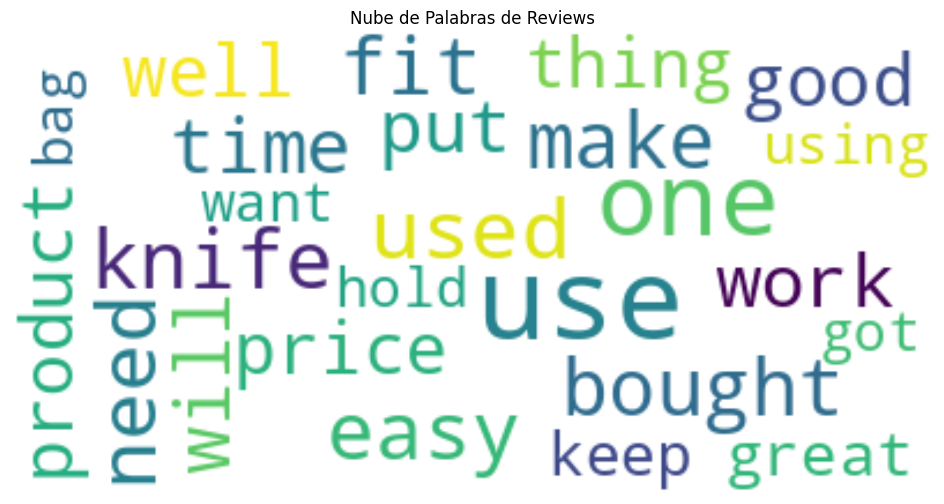

In [ ]:
text = ' '.join(df['reviewText'].dropna())
wordcloud = WordCloud(max_font_size=50, max_words=25, background_color="white").generate(text)
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Nube de Palabras de Reviews")
plt.show()

## Visualización en 2 dimensiones de algunos word embeddings calculados con Word2Vec (elegir 4-5 palabras y pintar las top 10 más similares)

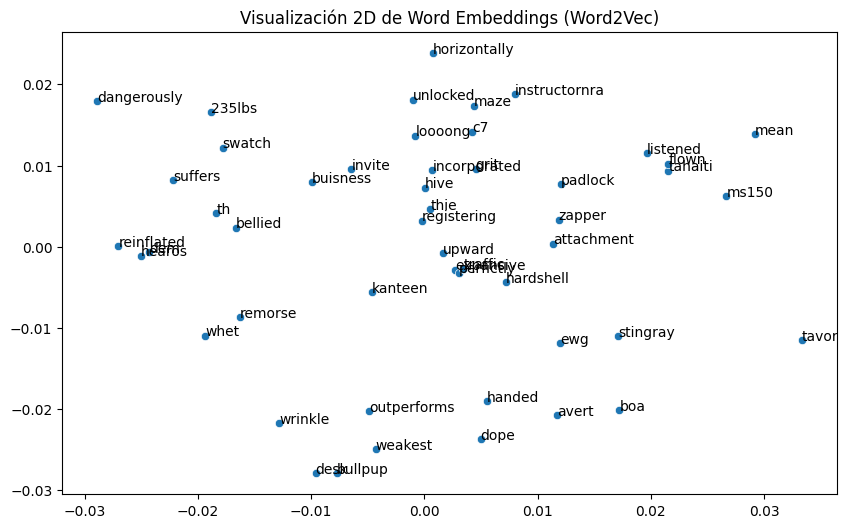

In [ ]:
# Entrenar modelo Word2Vec
model = Word2Vec(df['tokens'], min_count=5,
                     window=2,
                     vector_size=100,
                     sample=6e-5,
                     alpha=0.03,
                     min_alpha=0.0007,
                     negative=20,
                     workers=-1)

# Elegimos algunas palabras clave
words_to_plot = ["use", "one", "quality", "worth", "price"]
top_similar_words = {word: [w for w, _ in model.wv.most_similar(word, topn=10)] for word in words_to_plot}

# Obtener embeddings para visualización
word_vectors = np.array([model.wv[word] for word_list in top_similar_words.values() for word in word_list])
word_labels = [word for word_list in top_similar_words.values() for word in word_list]

# Reducción de dimensionalidad
pca = PCA(n_components=2)
word_vectors_pca = pca.fit_transform(word_vectors)

# Gráfica de las palabras en 2D
plt.figure(figsize=(10,6))
sns.scatterplot(x=word_vectors_pca[:,0], y=word_vectors_pca[:,1])

# Etiquetas
for i, word in enumerate(word_labels):
    plt.annotate(word, xy=(word_vectors_pca[i,0], word_vectors_pca[i,1]), fontsize=10)

plt.title("Visualización 2D de Word Embeddings (Word2Vec)")
plt.show()


## Conclusiones

* Cardinalidad del vocabulario: Se identificó un total de 294.822 palabras únicas, lo que indica la diversidad del corpus. Esto conlleva a la necesidad de un preprocesamiento adecuado para reducir la dimensionalidad (eliminación de palabras poco frecuentes o normalización de sinónimos).
* Distribución de Reviews: La mayoría de las reviews son de 4 o 5 estrellas, lo que sugiere un sesgo positivo en la percepción de los productos.
* Reviews Positivas vs Negativas: Se observa que predominan las reviews positivas en el dataset, lo que puede dificultar el balance de clases en el modelo.
* N-grams más frecuentes: Se destacan palabras relacionadas con la calidad, precio y experiencia de uso de los productos. Además se identificaron bigramas y trigramas representativos, lo que permite entender las expresiones más utilizadas en los reviews.
* Nube de palabras: Palabras como good, quality, works, great aparecen con más frecuencia. Se podría aplicar un análisis de sentimiento basado en palabras clave para una primera aproximación al sentimiento del texto.
* Word2Vec y embeddings: Se encontraron palabras semánticamente similares agrupadas, mostrando la efectividad del modelo de Word2Vec.

